# Importation des librairies, préparation de l'environnement

In [1]:
import cv2
from depth_anything_v2.dpt import DepthAnythingV2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
from sklearn.model_selection import train_test_split
from scipy.interpolate import griddata
import torch.optim as optim
import time

xFormers not available
xFormers not available


# Chargement du modèle DepthAnything

In [2]:
model = DepthAnythingV2(encoder="vits", features=64, out_channels=[48, 96, 192, 384])
modelOriginal = DepthAnythingV2(encoder="vits", features=64, out_channels=[48, 96, 192, 384])

In [3]:
model.load_state_dict(torch.load(f'depth_anything_v2_vits.pth', map_location='cpu'))
modelOriginal.load_state_dict(torch.load(f'depth_anything_v2_vits.pth', map_location='cpu'))

/var/folders/8c/9q4rw3jn16712tpdyjqy22l40000gn/T/ipykernel_75084/2602677827.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'depth_anyt

<All keys matched successfully>

### Essai avec une image

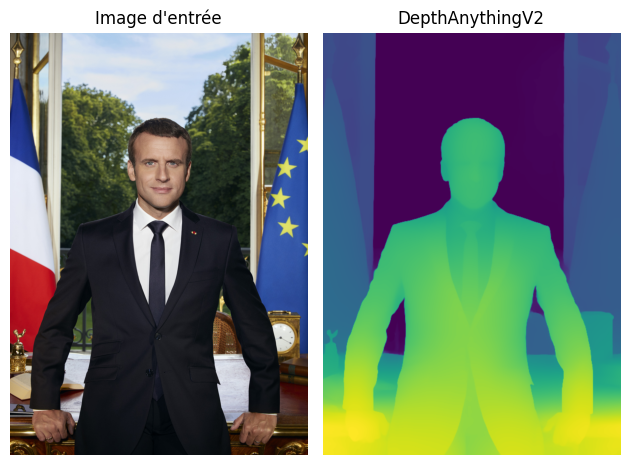

In [4]:
raw_img = cv2.imread("C:/Users/yoyoc/Desktop/portrait.jpeg")
depth = modelOriginal.infer_image(raw_img) # HxW raw depth map in numpy
plt.subplot(1, 2, 1)  # Première colonne
plt.imshow(cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB))  # Convertir BGR en RGB pour l'affichage
plt.axis("off")
plt.title("Image d'entrée")

plt.subplot(1, 2, 2) 
plt.imshow(depth, cmap="viridis")
plt.axis("off")
plt.title("DepthAnythingV2")

plt.tight_layout()
plt.show()

# Création d'une classe pour utiliser LoRA dans le modèle

In [5]:
class LoRALayer(nn.Module):
    def __init__(self, module, rank):
        super().__init__()
        self.module = module
        self.A_matrix = nn.Parameter(torch.empty(module.in_features, rank, device=module.weight.device))
        nn.init.kaiming_uniform_(self.A_matrix, a=5 ** 0.5)  # eviter vanishing gradient et exploding gradient
        self.B_matrix = nn.Parameter(torch.zeros(rank, module.out_features, device=module.weight.device))

    def forward(self, input):
        matrix_output = input @ self.A_matrix @ self.B_matrix
        return self.module(input) + matrix_output

### Fonction pour remplacer la couche actualisée dans le modèle

In [6]:
def replace_module(model, module_name, new_module):
    *parent_names, last_name = module_name.split('.')
    parent = model
    for name in parent_names:
        parent = getattr(parent, name)
    setattr(parent, last_name, new_module) # on remplace ici

### On applique LORA sur tous les blocs qui ont qkv (et/ou a d'autres couches)

In [7]:
def apply_lora_to_qkv(model, rank):
    for name, module in model.named_modules():
        if "qkv" in name:
            lora_module = LoRALayer(module, rank=rank)
            replace_module(model, name, lora_module)
            
def apply_lora_to_other_layers(model, rank):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):  # ou une autre couche
            lora_module = LoRALayer(module, rank)
            replace_module(model, name, lora_module)

def apply_lora_to_proj_layers(model, rank):
    for name, module in model.named_modules():
        if "proj" in name:
            lora_module = LoRALayer(module, rank=rank)
            replace_module(model, name, lora_module)

In [8]:
r = 8
# mettre ou on a appliquer lora dans la liste et enlever/mettre le # là ou on veut ajouter/enelevr lora
lora_applied_layers = ["qkv","linear"]
model = DepthAnythingV2(encoder="vits", features=64, out_channels=[48, 96, 192, 384])
apply_lora_to_qkv(model, rank=r)
apply_lora_to_other_layers(model, rank=r)
#apply_lora_to_conv_layers(model, rank=r)

### Gel des paramètres non LORA et rendre couches LORA entrainable

In [9]:
for param in model.parameters():
    param.requires_grad = False  # geler de tous les paramètres

for name, module in model.named_modules():
    if isinstance(module, LoRALayer):
        for param in module.parameters():
            param.requires_grad = True

### Vérification du remplacement des couches

In [10]:
nb_entrainable = 0
nb_non_entrainable = 0

for param in model.parameters():
    if param.requires_grad:
        nb_entrainable += 1
    else:
        nb_non_entrainable += 1

print(f"Nombre de paramètres entraînables (LORA) : {nb_entrainable}")
print(f"Nombre de paramètres non entraînables    : {nb_non_entrainable}")

Nombre de paramètres entraînables (LORA) : 216
Nombre de paramètres non entraînables    : 143


# Chargement des données - Classe Dataset

Attention, les données numpy sont données sous cette dimension : (1200,1944,3). Les deux premières composantes correspond au taille des images. La dernière composantes indique la vue utilisée pour la mesure de profondeur. La dimension 0 observe la profondeur relativement à l'axe X, la dimension 1 observe la profondeur relativement à l'axe Y, enfin, la dimension 2 observe la profondeur relativement à l'axe Z : ce qui correspond à la vue de la caméra :c'est donc cette dimension qu'il faut fournir au modèle !! 



Autre problème, les fichiers depth ont beaux être de même dimensions que les images, toute l'image n'est pas exploitée !! Une grande partie des numpy ont pleins de NaN !! 

### Mise en avant du problème des NaN dans les depth

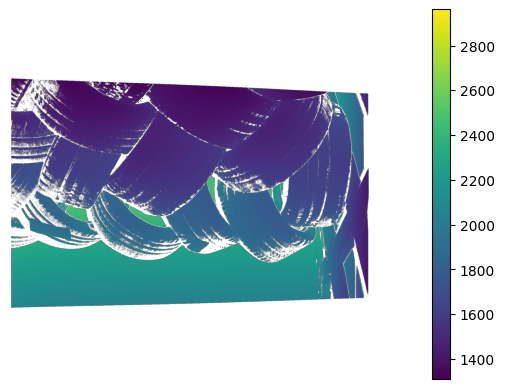

Min: 1310.6507568359375, Max: 2961.6015625
NaN count: 705660
1627.0679


In [11]:
#test chargement des depths numpy
depth = np.load("C:/Users/yoyoc/Desktop/DATASET_DEVOIR/DATASET_DEVOIR/depth/21-12-03-18-50-31_Zivid_acquisition_rawDepth.npy")
depth = depth[:,:,2]

plt.imshow(depth)
plt.axis('off')
plt.colorbar()
plt.show()
print(f"Min: {np.nanmin(depth)}, Max: {np.nanmax(depth)}")
print(f"NaN count: {np.isnan(depth).sum()}")
print(depth[600,600])

In [12]:
def fill_nan_with_interpolation(depth):
    # Créer une grille pour les coordonnées
    x, y = np.meshgrid(np.arange(depth.shape[1]), np.arange(depth.shape[0]))
    # Identifier les positions non-NaN
    valid_mask = ~np.isnan(depth)
    # Interpolation
    depth_filled = griddata(
        (x[valid_mask], y[valid_mask]),  # Coordonnées valides
        depth[valid_mask],  # Valeurs valides
        (x, y),  # Coordonnées complètes
        method='linear',  # Méthode d'interpolation (linéaire ou autre)
        fill_value=1800  # Valeur par défaut si interpolation impossible
    )
    return depth_filled

In [13]:
class DepthDataset(Dataset):
    def __init__(self, image_dir, image_files, depth_dir, depth_files, image_scale):
        self.image_dir = image_dir
        self.depth_dir = depth_dir
        self.image_files = image_files
        self.depth_files = depth_files
        self.image_scale = image_scale

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        depth_path = os.path.join(self.depth_dir, self.depth_files[idx])

        # Chargement et traitement de l'image
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        ratio_images = 1944 / 1200
        new_width = 14 * self.image_scale
        new_height = 14 * int(self.image_scale / ratio_images)
        image = cv2.resize(image, (new_width, new_height))
        image = image / 255.0 # normalisation
        
        # Chargement et traitement de la carte de profondeur
        depth = np.load(depth_path)
        depth = depth[:, :, 2]  # on récupère uniquement la 3e vue de profondeur (axe Z)
        
        depth = cv2.resize(depth, (new_width, new_height))
        depth = fill_nan_with_interpolation(depth)

        return {"image": image, "depth": depth}

In [14]:
# Paramètres
img_scale = 10
batch = 4
valtrain_size = 0.6

IMAGES_DIR = "C:/Users/yoyoc/Desktop/DATASET_DEVOIR/DATASET_DEVOIR/images"
DEPTH_DIR = "C:/Users/yoyoc/Desktop/DATASET_DEVOIR/DATASET_DEVOIR/depth"

# On trie les listes de fichiers pour faire coincider chaque image avec son nuage de points
images_files = sorted(os.listdir(IMAGES_DIR))
depth_files = sorted(os.listdir(DEPTH_DIR))

train_indices, val_indices = train_test_split(range(len(images_files)), train_size=valtrain_size, random_state=2025) # séparation train/validation
train_images = [images_files[indice] for indice in train_indices]
val_images = [images_files[indice] for indice in val_indices]
train_depth = [depth_files[indice] for indice in train_indices]
val_depth = [depth_files[indice] for indice in val_indices]

train_dataset = DepthDataset(IMAGES_DIR, train_images, DEPTH_DIR, train_depth, img_scale)
val_datatset = DepthDataset(IMAGES_DIR, val_images, DEPTH_DIR, val_depth, img_scale)

# dataloader
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_datatset, batch_size=batch, shuffle=True)

### Test du bon fonctionnement du dataset et du dataloader

In [15]:
print(f"Le train dataloader contient {len(train_loader.dataset.image_files)} éléments")
print(f"Le validation dataloader contient {len(val_loader.dataset.image_files)} éléments")

Le train dataloader a 34 éléments
Le validation dataloader a 24 éléments


Dimensions de l'image = (84, 140, 3)
Dimensions du depth = (84, 140)


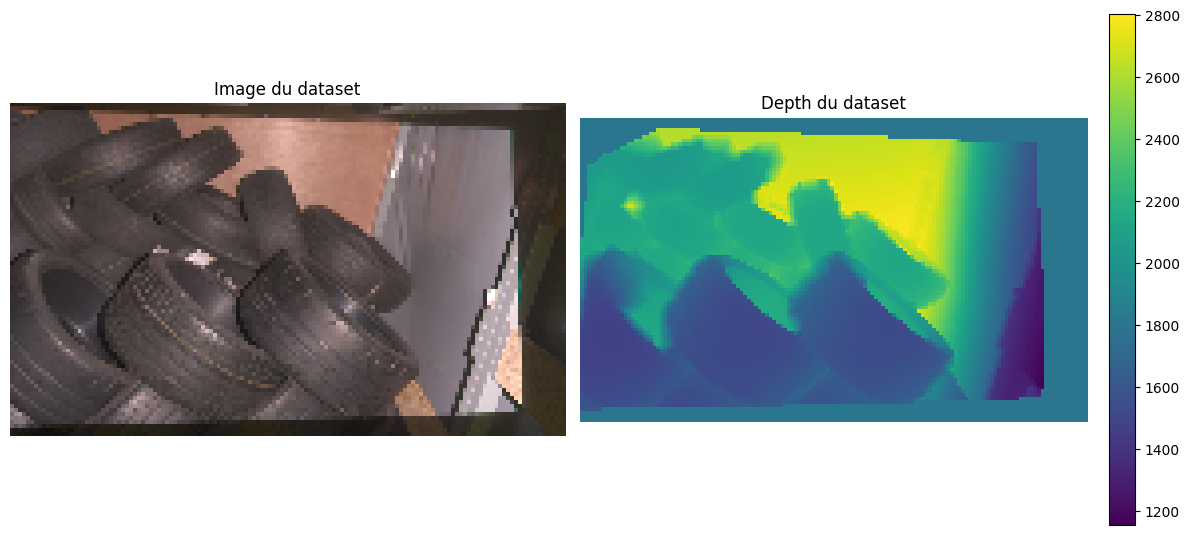

In [16]:
num_img = 0 # numéro de l'image qu'on veut visualiser

plt.figure(figsize=(12, 6))

img = train_dataset[num_img]["image"]
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")
plt.title("Image du dataset")
print(f"Dimensions de l'image = {img.shape}")

prof = train_dataset[num_img]["depth"]
plt.subplot(1, 2, 2)
plt.imshow(prof, cmap="viridis")
plt.axis("off")
plt.title("Depth du dataset")
plt.colorbar(fraction=0.046, pad=0.04)
print(f"Dimensions du depth = {prof.shape}")

plt.tight_layout()
plt.show()

# Fine-Tunning

Nous pensons qu'il est normal qu'avec un faible nombre d'epoch, le modèle soit bon. En effet, les couches LoRA n'ont pas été fortement modifié, le modèle avec LoRA ressemble donc beaucoup au DepthAnything original. À l'inverse, dès qu'on augmente un peu le nombre d'epoch, le modèle change ses paramètres, ce qui change fatalement la qualité des images.

In [17]:
img_scale = 10
nbbatch = 4
valtrain_size = 0.2
alpha = 1e-4
num_epochs = 25
hist = [] # historique des loss
loss_name = "sill"  # choix de la loss

# On recharge le dataloader mais avec les paramètres ci dessus
train_indices, val_indices = train_test_split(range(len(images_files)), train_size=valtrain_size, random_state=2025) # séparation train/validation
train_images = [images_files[indice] for indice in train_indices]
val_images = [images_files[indice] for indice in val_indices]
train_depth = [depth_files[indice] for indice in train_indices]
val_depth = [depth_files[indice] for indice in val_indices]

# datasets
train_dataset = DepthDataset(IMAGES_DIR, train_images, DEPTH_DIR, train_depth, img_scale)
val_datatset = DepthDataset(IMAGES_DIR, val_images, DEPTH_DIR, val_depth, img_scale)

# dataloader
train_loader = DataLoader(train_dataset, batch_size=nbbatch, shuffle=True)
val_loader = DataLoader(val_datatset, batch_size=nbbatch, shuffle=True)

In [18]:
optimizer = optim.Adam([param for param in model.parameters() if param.requires_grad], lr=alpha, weight_decay=1e-5)  # weight decay pour éviter le surapprentissage

def loss_MSE(predicted_depth, true_depth):
    return torch.mean((predicted_depth - true_depth) ** 2)
    
def loss_MAE(predicted_depth, true_depth):
    return torch.mean(torch.abs(predicted_depth - true_depth))

def loss_SILL(predicted_depth, true_depth):
    diff = torch.log(predicted_depth + 1e-6) - torch.log(true_depth + 1e-6)
    return torch.mean(diff**2) - (torch.mean(diff)**2)

def scale_shift_invariant_loss(predictions, targets, alpha=1.0, beta=1.0):
    # Calcul de la différence entre les prédictions et les cibles
    diff = predictions - targets
    # Composante Scale : Calcul du changement de mise à l'échelle
    scale_loss = torch.mean(torch.abs(diff))  # Moyenne de l'erreur absolue
    # Composante Shift : Calcul de la translation (ici avec une norme L2)
    shift_loss = torch.mean(diff ** 2)  # Moyenne de l'erreur au carré (L2)
    # Combinaison des deux composantes
    total_loss = alpha * scale_loss + beta * shift_loss
    return total_loss

loss_functions = {
    "mse": loss_MSE,
    "mae": loss_MAE,
    "sill": loss_SILL,
    "ssi" : scale_shift_invariant_loss
}

if loss_name not in loss_functions:
    raise ValueError(f"Invalid loss_name '{loss_name}'. Choose a loss in this list : {list(loss_functions.keys())}")

loss_fn = loss_functions[loss_name]

# pour avoir tous les specs de ce qui tourne actuellement
print(f'{num_epochs} epochs, {nbbatch} batch, LoRA rank {r} on: {lora_applied_layers}, imgscale:{img_scale}, on {len(train_loader.dataset.image_files)} images and loss : {loss_name}')

start_time = time.time()

for epoch in range(num_epochs):
    model.train()  # Passer en mode entraînement
    running_loss = 0.0
    for batch in train_loader:
        images = batch['image'].float().clone().detach().permute(0, 3, 1, 2)
        depths = batch['depth'].float().clone().detach()
        
        optimizer.zero_grad() # Remise à zéro des gradients
        
        outputs = model(images) # Le modèle fait la prédiction
        
        loss = loss_fn(outputs, depths)
        
        loss.backward() # Rétropropagation et mise à jour des poids
        
        optimizer.step()
        
        running_loss += loss.item()
    
    if epoch == 0 : # affichage des dimensions d'images et d'output pour diagnostic
        print(f"Dimensions des images = {images.shape}")
        print(f"Dimensions des depths = {depths.shape}")
        print(f"Dimensions des outputs = {outputs.shape}")

    avg_loss = running_loss / len(train_loader)
    hist.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

end_time = time.time()

print(end_time - start_time)

25 epochs, 4 batch, LoRA rank 8 on: ['qkv', 'linear'], imgscale:10, on 11 images and loss : sill
Dimensions des images = torch.Size([3, 3, 84, 140])
Dimensions des depths = torch.Size([3, 84, 140])
Dimensions des outputs = torch.Size([3, 84, 140])
Epoch [1/25], Loss: 0.1030
Epoch [2/25], Loss: 0.0945
Epoch [3/25], Loss: 0.0943
Epoch [4/25], Loss: 0.0908
Epoch [5/25], Loss: 0.0834
Epoch [6/25], Loss: 0.0776
Epoch [7/25], Loss: 0.0754
Epoch [8/25], Loss: 0.0663
Epoch [9/25], Loss: 0.0650
Epoch [10/25], Loss: 0.0591
Epoch [11/25], Loss: 0.0525
Epoch [12/25], Loss: 0.0499
Epoch [13/25], Loss: 0.0454
Epoch [14/25], Loss: 0.0481
Epoch [15/25], Loss: 0.0456
Epoch [16/25], Loss: 0.0424
Epoch [17/25], Loss: 0.0414
Epoch [18/25], Loss: 0.0520
Epoch [19/25], Loss: 0.0444
Epoch [20/25], Loss: 0.0383
Epoch [21/25], Loss: 0.0346
Epoch [22/25], Loss: 0.0350
Epoch [23/25], Loss: 0.0313
Epoch [24/25], Loss: 0.0281
Epoch [25/25], Loss: 0.0289
127.56913471221924


### Enregistrement des poids du modèle.

In [19]:
torch.save(model.state_dict(), "fine_tuned_model.pth")
print("modèle sauvegardé sous fine_tuned_model.pth")

modèle sauvegardé sous fine_tuned_model.pth


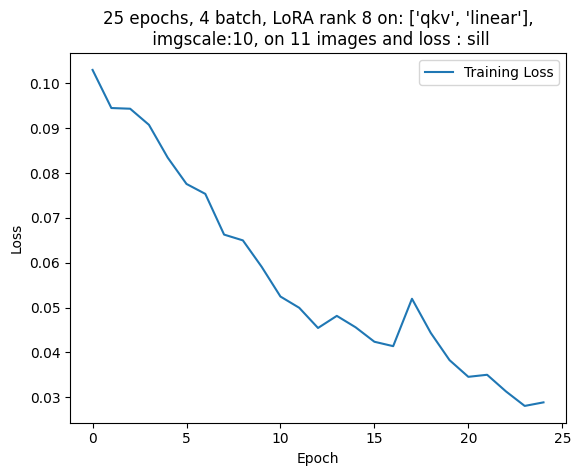

In [24]:
# diagnostic du modèle...
plt.plot(hist, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{num_epochs} epochs, {nbbatch} batch, LoRA rank {r} on: {lora_applied_layers},\n imgscale:{img_scale}, on {len(train_loader.dataset.image_files)} images and loss : {loss_name}')
plt.legend()
plt.savefig("Loss")
plt.show()

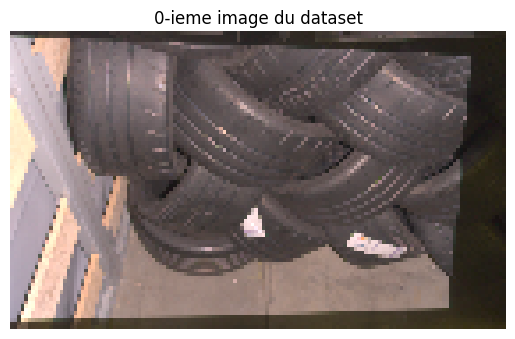

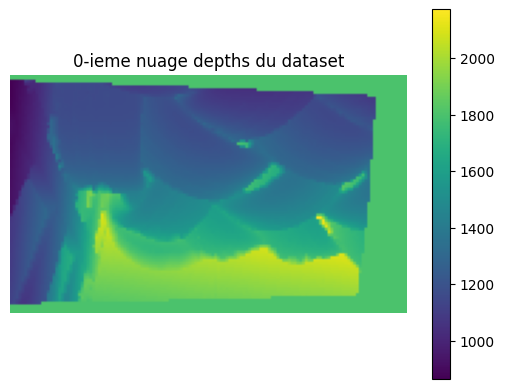

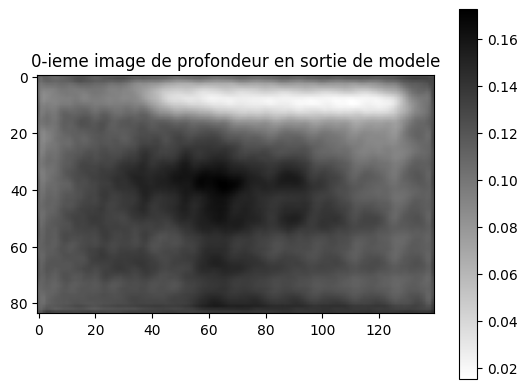

In [21]:
num_img = 0

plt.imshow(train_dataset[num_img]["image"])
plt.axis("off")
plt.title(f"{num_img}-ieme image du dataset")
plt.show()

plt.imshow(train_dataset[num_img]["depth"])
plt.axis("off")
plt.colorbar()
plt.title(f"{num_img}-ieme nuage depths du dataset")
plt.show()


first_output = outputs[num_img,:,:]
first_output_np = first_output.detach().cpu().numpy()
plt.imshow(first_output_np, cmap='gray_r')
plt.colorbar()
plt.title(f"{num_img}-ieme image de profondeur en sortie de modele")
plt.show()

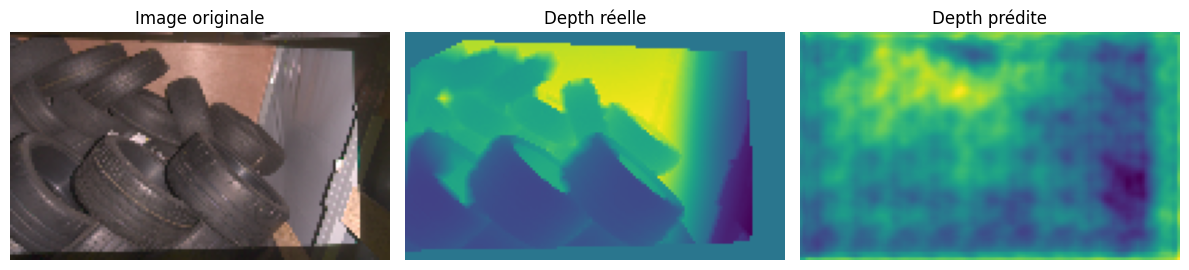

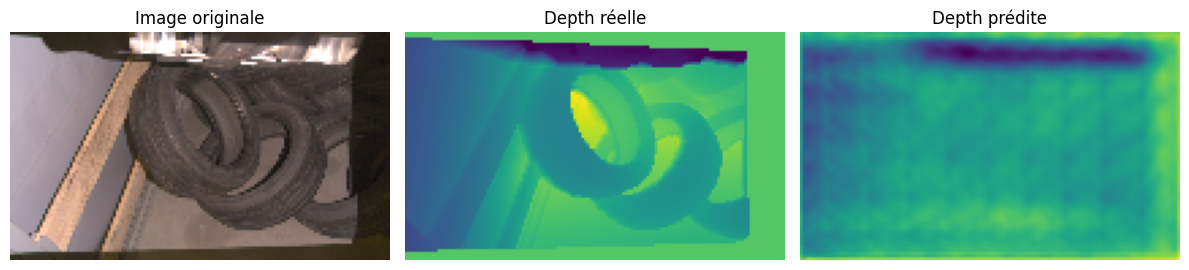

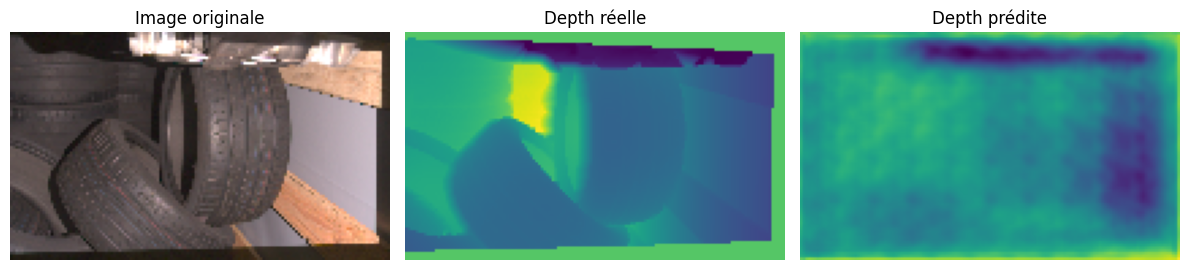

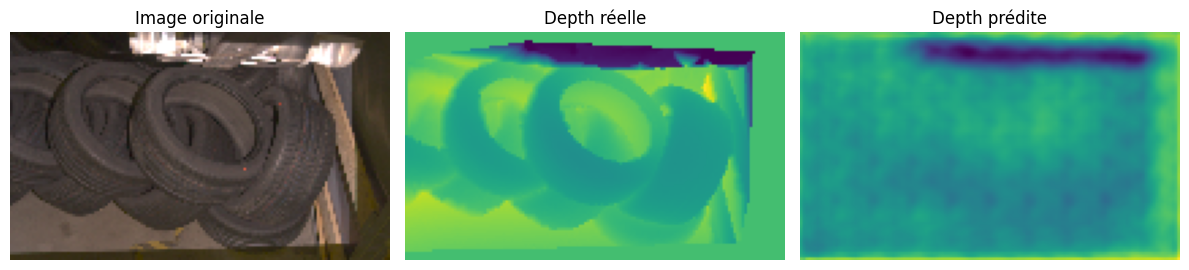

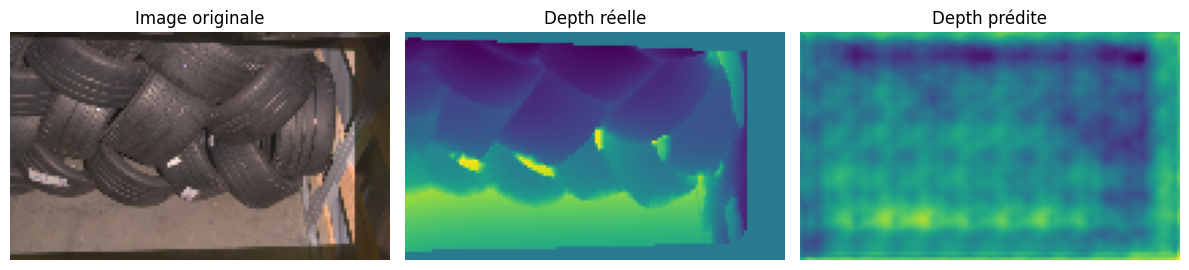

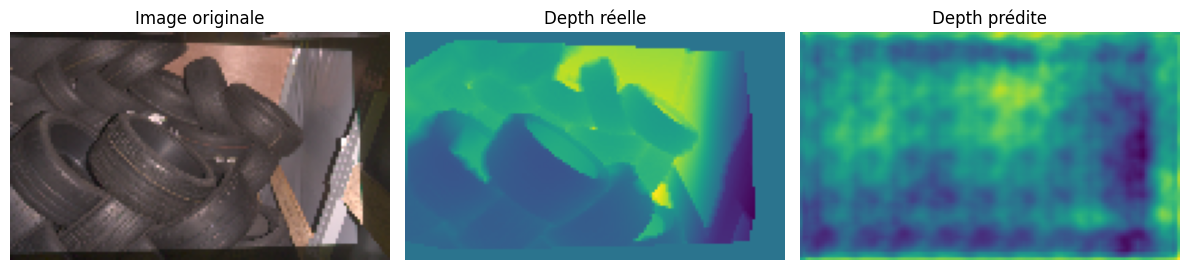

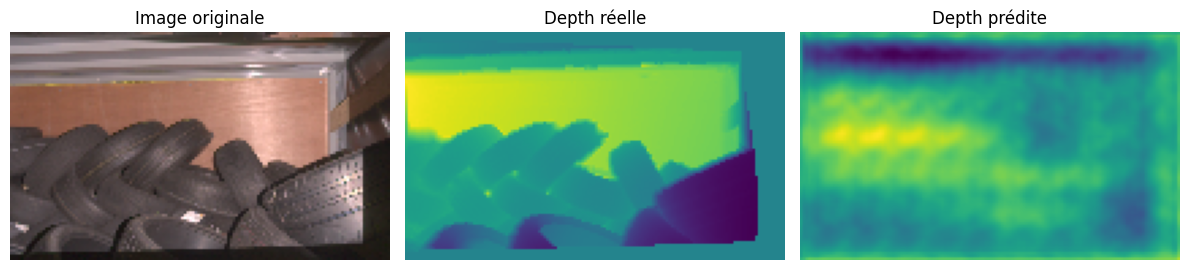

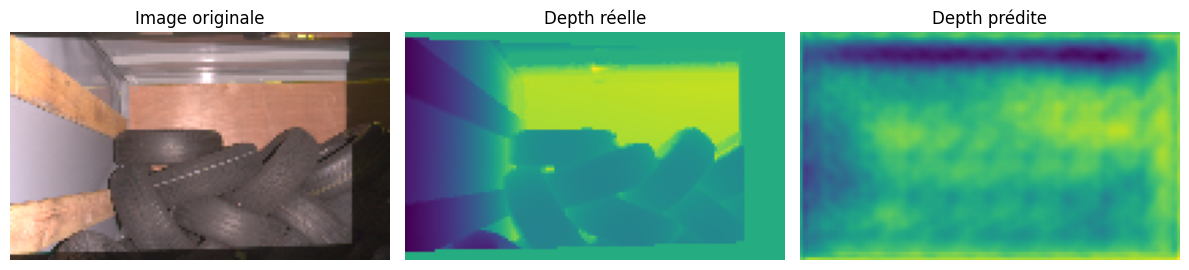

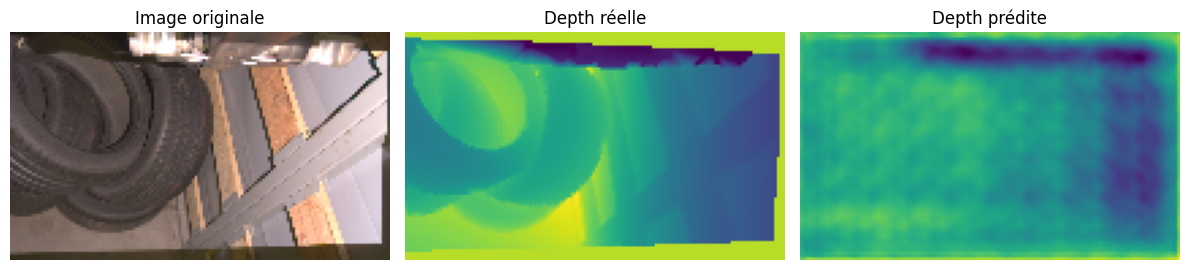

Validation Loss: 0.0566


In [23]:
model.eval()  # on evalue :)
val_loss = 0.0

with torch.no_grad():
    for i, batch in enumerate(val_loader):
        images = batch['image'].float().clone().detach().permute(0, 3, 1, 2)
        depths = batch['depth'].float().clone().detach()
        outputs = model(images)
        loss = loss_fn(outputs, depths)
        val_loss += loss.item()

        if i < 3: # on affiche quelques images
            for j in range(min(len(images), 3)):
                plt.figure(figsize=(12, 4))
                
                plt.subplot(1, 3, 1)
                plt.imshow(images[j].permute(1, 2, 0).cpu().numpy())
                plt.axis("off")
                plt.title("Image originale")
                
                # depth du dataset
                plt.subplot(1, 3, 2)
                plt.imshow(depths[j].cpu().numpy(), cmap="viridis")
                plt.axis("off")
                plt.title("Depth réelle")
                
                # depth predite par LoRA
                plt.subplot(1, 3, 3)
                plt.imshow(outputs[j].cpu().numpy(), cmap="viridis")
                plt.axis("off")
                plt.title("Depth prédite")
                
                plt.tight_layout()
                plt.show()

avg_val_loss = val_loss / len(val_loader)
print(f'Validation Loss: {avg_val_loss:.4f}')